In [68]:
# Import dataset
import pandas as pd
url = 'https://raw.githubusercontent.com/enhatl/ML-Semester-Proj/main/dataset.csv'
df = pd.read_csv(url,index_col=0)

# Decision Tree

In [69]:
# Imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.calibration import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Data Preprocessing

In [70]:
df_dt = df.copy() #make copy so that we can prepare the data correctly

#unique variable, will not be useful to us
df_dt = df_dt.drop('track_id', axis=1)
#album name and track name are not going to be useful either
df_dt = df_dt.drop(['album_name','track_name'], axis=1)

In [71]:
#artist name can be useful, but need to get them as numerical values

label_encoder = LabelEncoder()

#We are assuming the first artist is the main artist and will give the most information.
df_dt['artist_encoded'] = df_dt['artists'].str.split(',').str[0].str.strip()  #Extract first artist
df_dt['artist_encoded'] = label_encoder.fit_transform(df_dt['artist_encoded'])  #Apply label encoding

X= df_dt.drop(['track_genre', 'artists'], axis=1) #dont need artists column anymore
y = df_dt['track_genre']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [73]:
y_pred = tree_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{confusion_mat}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.23390350877192984
Confusion Matrix:
[[29  0  0 ...  2  1  3]
 [ 1 42  0 ... 12  0  1]
 [ 1  0 11 ...  0  1  5]
 ...
 [ 0 12  3 ... 21  1  1]
 [ 0  1  4 ...  0 34  1]
 [ 1  0  9 ...  0  1 45]]
Classification Report:
                   precision    recall  f1-score   support

         acoustic       0.14      0.14      0.14       213
         afrobeat       0.19      0.21      0.20       203
         alt-rock       0.03      0.05      0.04       215
      alternative       0.07      0.10      0.08       184
          ambient       0.17      0.19      0.18       197
            anime       0.09      0.12      0.11       193
      black-metal       0.43      0.46      0.45       210
        bluegrass       0.33      0.26      0.29       205
            blues       0.12      0.16      0.14       214
           brazil       0.08      0.12      0.10       197
        breakbeat       0.36      0.35      0.35       199
          british       0.11      0.10      0.10       214
     

We want to improve that base accuracy. Lets try grid search for an optimal depth.

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7, 10]}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_max_depth = grid_search.best_params_['max_depth']

# Use the best hyperparameters to train the pruned tree
pruned_tree = DecisionTreeClassifier(max_depth=best_max_depth)
pruned_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [75]:
y_pred_pruned = pruned_tree.predict(X_test)

accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
confusion_mat_pruned = confusion_matrix(y_test, y_pred_pruned)
classification_rep_pruned = classification_report(y_test, y_pred_pruned)

print(f"Accuracy: {accuracy_pruned}")
print(f"Confusion Matrix:\n{confusion_mat_pruned}")
print(f"Classification Report:\n{classification_rep_pruned}")

c:\Users\Emily\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Emily\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2144298245614035
Confusion Matrix:
[[ 0  0  0 ...  0  4  0]
 [ 0 50  0 ...  2  1  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0 16  0 ...  8  2  0]
 [ 0  0  0 ...  0 44  0]
 [ 0  0  0 ...  0  1  1]]
Classification Report:
                   precision    recall  f1-score   support

         acoustic       0.00      0.00      0.00       213
         afrobeat       0.18      0.25      0.21       203
         alt-rock       0.00      0.00      0.00       215
      alternative       0.05      0.05      0.05       184
          ambient       0.23      0.35      0.28       197
            anime       0.50      0.01      0.02       193
      black-metal       0.52      0.54      0.53       210
        bluegrass       0.20      0.33      0.25       205
            blues       0.19      0.03      0.05       214
           brazil       0.24      0.23      0.24       197
        breakbeat       0.47      0.29      0.36       199
          british       0.16      0.05      0.07       214
      

c:\Users\Emily\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy still isn't great. Lets try binning some of our attributes. This has a trade off of some information loss, but having the precise value of some of our attributes isn't neccessary.

Let's bin these variables : popularity, duration_ms, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, and tempo. We set the bins based on the data description given in the readme file.

In [76]:
#make new dataframe so that we dont mess up the old one
X_new = X.copy()

In [77]:
popularity_bins = [0, 25, 50, 75, 100]
popularity_labels = ['Very Low', 'Low', 'Moderate', 'High']

duration_bins = [0, 180000, 200000, 220000, float('inf')]
duration_labels = ['Short', 'Medium', 'Long', 'Very Long']

danceability_bins = [0, 0.5, 0.7, 0.8, 1.0]
danceability_labels = ['Low', 'Moderate', 'High', 'Very High']

energy_bins = [0, 0.4, 0.6, 0.8, 1.0]
energy_labels = ['Low', 'Moderate', 'High', 'Very High']

loudness_bins = [-float('inf'), -8.0, -6.0, -4.0, 0]
loudness_labels = ['Very Low', 'Low', 'Moderate', 'High']

speechiness_bins = [0, 0.33, 0.66, 1.0]
speechiness_labels = ['Music', 'Mixed', 'Speech']

acousticness_bins = [0, 0.2, 0.4, 0.6, 1.0]
acousticness_labels = ['Low', 'Moderate', 'High', 'Very High']

instrumentalness_bins = [0, 0.2, 0.4, 0.6, 1.0]
instrumentalness_labels = ['Low', 'Moderate', 'High', 'Very High']

liveness_bins = [0, 0.2, 0.4, 0.6, 1.0]
liveness_labels = ['Low', 'Moderate', 'High', 'Very High']

valence_bins = [0, 0.25, 0.5, 0.75, 1.0]
valence_labels = ['Low', 'Moderate', 'High', 'Very High']

tempo_bins = [0, 90, 110, 130, float('inf')]
tempo_labels = ['Very Slow', 'Slow', 'Moderate', 'Fast']

X_new['popularity_bin'] = pd.cut(X_new['popularity'], bins=popularity_bins, labels=popularity_labels)
X_new['duration_bin'] = pd.cut(X_new['duration_ms'], bins=duration_bins, labels=duration_labels)
X_new['danceability_bin'] = pd.cut(X_new['danceability'], bins=danceability_bins, labels=danceability_labels)
X_new['energy_bin'] = pd.cut(X_new['energy'], bins=energy_bins, labels=energy_labels)
X_new['loudness_bin'] = pd.cut(X_new['loudness'], bins=loudness_bins, labels=loudness_labels)
X_new['speechiness_bin'] = pd.cut(X_new['speechiness'], bins=speechiness_bins, labels=speechiness_labels)
X_new['acousticness_bin'] = pd.cut(X_new['acousticness'], bins=acousticness_bins, labels=acousticness_labels)
X_new['instrumentalness_bin'] = pd.cut(X_new['instrumentalness'], bins=instrumentalness_bins, labels=instrumentalness_labels)
X_new['liveness_bin'] = pd.cut(X_new['liveness'], bins=liveness_bins, labels=liveness_labels)
X_new['valence_bin'] = pd.cut(X_new['valence'], bins=valence_bins, labels=valence_labels)
X_new['tempo_bin'] = pd.cut(X_new['tempo'], bins=tempo_bins, labels=tempo_labels)


In [78]:
X_new.drop(['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
            'liveness', 'valence', 'tempo'], axis=1, inplace=True)
#need numerical not categorical data
label_encoder = LabelEncoder()
X_new_encoded = X_new.apply(label_encoder.fit_transform)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_new_encoded, y, test_size=0.2, random_state=42)

param_grid = {'max_depth': [3, 5, 7, 10]}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_max_depth = grid_search.best_params_['max_depth']

# Use the best hyperparameters to train the pruned tree
pruned_binned_tree = DecisionTreeClassifier(max_depth=best_max_depth)
pruned_binned_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [80]:
y_pred_pruned = pruned_binned_tree.predict(X_test)

accuracy_pruned_binned = accuracy_score(y_test, y_pred_pruned)
confusion_mat_pruned_binned = confusion_matrix(y_test, y_pred_pruned)
classification_rep_pruned_binned = classification_report(y_test, y_pred_pruned)

print(f"Accuracy: {accuracy_pruned_binned}")
print(f"Confusion Matrix:\n{confusion_mat_pruned_binned}")
print(f"Classification Report:\n{classification_rep_pruned_binned}")

c:\Users\Emily\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Emily\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.17162280701754387
Confusion Matrix:
[[12  0  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Classification Report:
                   precision    recall  f1-score   support

         acoustic       0.15      0.06      0.08       213
         afrobeat       0.67      0.01      0.02       203
         alt-rock       0.08      0.07      0.07       215
      alternative       0.06      0.03      0.04       184
          ambient       0.38      0.16      0.22       197
            anime       0.07      0.06      0.06       193
      black-metal       0.20      0.51      0.28       210
        bluegrass       0.09      0.18      0.12       205
            blues       0.33      0.13      0.19       214
           brazil       0.00      0.00      0.00       197
        breakbeat       0.13      0.08      0.09       199
          british       0.18      0.03      0.05       214
     

c:\Users\Emily\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Even after binning and re-prunning our tree, we still are stuck at below 25% accuracy. Since we have seemingly exhausted our options for improving our tree, we can safely assume that decision tree is not a great algorithm for our goal. Alternatively, maybe our data just is not capable of making a good prediction overall.

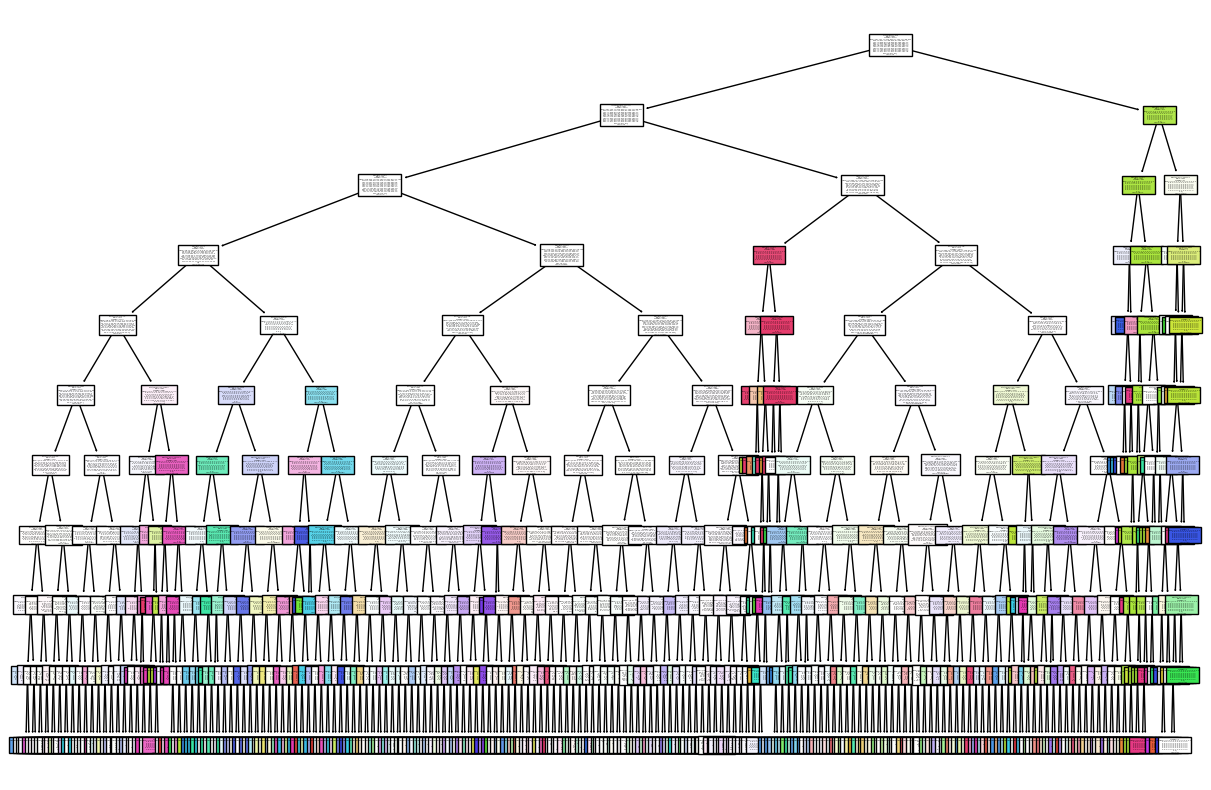

In [81]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names = list(X.columns)

plt.figure(figsize=(15, 10))
plot_tree(pruned_tree, filled=True, feature_names=feature_names, class_names=list(map(str, pruned_tree.classes_)))
plt.show()

# Naive Bayes

In [ ]:
df_nb = df.copy()

# Logistic Regression

In [ ]:
df_lr = df.copy()

# Support Vector Machine

In [ ]:
df_svm = df.copy()

# Multi-Layer Perceptron

In [ ]:
df_mlp = df.copy()